In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from models.sub_clust_cos_glm import Sub_Clust_Cos_GLM
from models.clust_gru import Clust_GRU

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
#E_neural_file = "Espikes_neural.npz"
#I_neural_file = "Ispikes_neural.npz"
model_type = "gru"
rep = 2

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_clust4-60/data/Espikes_neural.npz")
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_clust4-60/data/Ispikes_neural.npz")

In [3]:
H_no = 20
sub_no = 5
E_no = 2000
I_no = 200
T_no = 500
device = torch.device("cuda")

In [4]:
if model_type == "gru":
    model = Clust_GRU(sub_no, E_no, I_no, H_no, device)
elif model_type == "glm":
    model = Sub_Clust_Cos_GLM(sub_no, E_no, I_no, T_no, H_no, device)
    
model.to(device).float()
model.load_state_dict(torch.load(base_dir+cell_type+"_"+experiment+"/clust/"+model_type+"_s"+str(sub_no)+"_h"+str(H_no)+"_pretrain_set"+str(rep)+".pt", map_location=device))
model.eval()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

20206


In [5]:
if (model_type == "gru"):
    test = np.zeros((20,50000))
    sub_out = np.zeros((20, sub_no, 50000))

    for i in tnrange(20):
        if i < 19:
            part_E_neural = torch.from_numpy(E_neural[(-20+i)*50000:(-19+i)*50000].toarray()).to(device).float().unsqueeze(0)
            part_I_neural = torch.from_numpy(I_neural[(-20+i)*50000:(-19+i)*50000].toarray()).to(device).float().unsqueeze(0)
        elif i == 19:
            part_E_neural = torch.from_numpy(E_neural[(-20+i)*50000:].toarray()).to(device).float().unsqueeze(0)
            part_I_neural = torch.from_numpy(I_neural[(-20+i)*50000:].toarray()).to(device).float().unsqueeze(0)
        
        part_test, part_sub_out, C_syn_e, C_syn_i = model(part_E_neural, part_I_neural, 0.0001)
        test[i] = part_test.cpu().detach().numpy().flatten()
        sub_out[i] = part_sub_out.squeeze(0).T.cpu().detach().numpy()
        
    E_scale = np.exp(model.E_scale.cpu().detach().numpy())
    C_syn_e = C_syn_e.cpu().detach().numpy()
    C_syn_i = C_syn_i.cpu().detach().numpy()
    
    np.savez(base_dir+cell_type+"_"+experiment+"/clust/"+model_type+"_s"+str(sub_no)+"_h"+str(H_no)+"_pretrain_output_set"+str(rep)+".npz",
        test=test,
        sub_out=sub_out,
        E_scale = E_scale,
            C_syn_e = C_syn_e,
            C_syn_i = C_syn_i)

    
elif (model_type == "glm"):
    test = np.zeros((20,50000))
    nonlin_in = np.zeros((20,sub_no,H_no, 50000))
    sub_out = np.zeros((20, sub_no, 50000))
    
    for i in tnrange(20):
        if i < 19:
            part_E_neural = torch.from_numpy(E_neural[(-20+i)*50000:(-19+i)*50000].toarray()).to(device).float().unsqueeze(0)
            part_I_neural = torch.from_numpy(I_neural[(-20+i)*50000:(-19+i)*50000].toarray()).to(device).float().unsqueeze(0)
        elif i == 19:
            part_E_neural = torch.from_numpy(E_neural[(-20+i)*50000:].toarray()).to(device).float().unsqueeze(0)
            part_I_neural = torch.from_numpy(I_neural[(-20+i)*50000:].toarray()).to(device).float().unsqueeze(0)

        part_test, part_sub_out, C_syn_e, C_syn_i = model(part_E_neural, part_I_neural, 0.0001)
        test[i] = part_test.cpu().detach().numpy().flatten()
        sub_out[i] = part_sub_out.squeeze(0).T.cpu().detach().numpy()
        
    C_syn_e = C_syn_e.cpu().detach().numpy()
    C_syn_i = C_syn_i.cpu().detach().numpy()
        
    cos_basis_no = 30
    scale = 7.5
    shift = 1
        
    kern_basis = torch.zeros(cos_basis_no, T_no).to(device)
    for i in range(cos_basis_no):
        phi = 1.5707963267948966*i
        xmin = phi - 3.141592653589793
        xmax = phi + 3.141592653589793

        x_in = torch.arange(0, T_no, 1)
        raw_cos = scale  * torch.log(x_in + shift + 1e-7)

        basis = 0.5*torch.cos(raw_cos - phi) + 0.5
        basis[raw_cos < xmin] = 0.0
        basis[raw_cos > xmax] = 0.0
        kern_basis[i] = basis
        
    e_kern = torch.matmul(model.W_e_layer1, kern_basis).reshape(sub_no, H_no, T_no).cpu().detach().numpy()
    i_kern = torch.matmul(model.W_i_layer1, kern_basis).reshape(sub_no, H_no, T_no).cpu().detach().numpy()
    
    E_scale = np.exp(model.E_scale.cpu().detach().numpy())
    np.savez(base_dir+cell_type+"_"+experiment+"/clust/"+model_type+"_s"+str(sub_no)+"_h"+str(H_no)+"_pretrain_output_set"+str(rep)+".npz",
        test=test,
        nonlin_in=nonlin_in,
        sub_out=sub_out,
        e_kern=e_kern,
        i_kern=i_kern,
        E_scale=E_scale,
            C_syn_e = C_syn_e,
            C_syn_i = C_syn_i)


/tmp/ipykernel_20254/3393471792.py:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(20):


  0%|          | 0/20 [00:00<?, ?it/s]

In [8]:
v = np.load("/media/hdd01/sklee/CA1_clust4-60/data/V_diff_stimseed1.npy")[-20*50000:].reshape(20,50000)
test = np.load("/media/hdd01/sklee/CA1_clust4-60/clust/gru_s5_h20_pretrain_output_set2.npz")["test"]

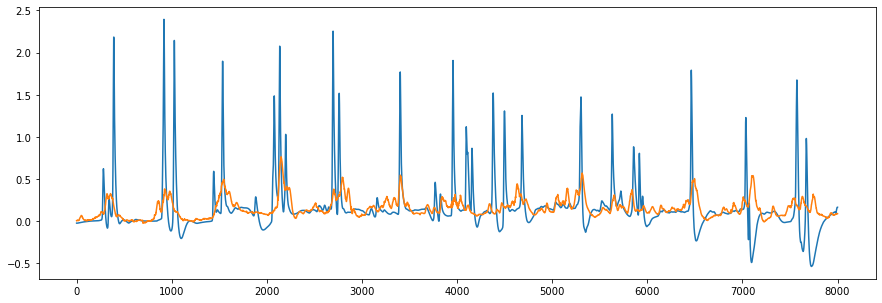

In [9]:
plt.figure(figsize = (15,5))
plt.plot(v[1][18000:26000])
plt.plot(test[1][18000:26000])

In [11]:
v = np.load("/media/hdd01/sklee/CA1_clust4-60_noNA/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1_set2.npy")[-20:,:50000].reshape(20,50000)
v -= np.mean(np.load("/media/hdd01/sklee/CA1_clust4-60_noNA/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1_set2.npy"))
test = np.load("/media/hdd01/sklee/CA1_clust4-60_noNA/clust/gru_s5_h20_pretrain_output_rep2.npz")["test"]

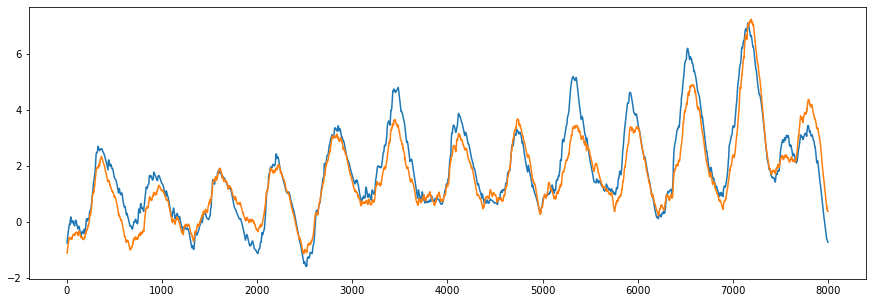

In [12]:
plt.figure(figsize = (15,5))
plt.plot(v[2][18000:26000])
plt.plot(test[2][18000:26000])